In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import missingno as msno
from plotly import __version__
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objs as go 
init_notebook_mode(connected=True) 
import calendar

### District information data

The district file `districts_info.csv` includes information about the characteristics of school districts, including data from [NCES](https://nces.ed.gov/) (2018-19), [FCC](https://www.fcc.gov/) (Dec 2018), and [Edunomics Lab](https://edunomicslab.org/). In this data set, we removed the identifiable information about the school districts. We also used an open source tool [ARX](https://arx.deidentifier.org/) [(Prasser et al. 2020)](https://onlinelibrary.wiley.com/doi/full/10.1002/spe.2812) to transform several data fields and reduce the risks of re-identification. For data generalization purposes some data points are released with a range where the actual value falls under. Additionally, there are many missing data marked as 'NaN' indicating that the data was suppressed to maximize anonymization of the dataset. 

| Name | Description |
| :--- | :----------- |
| district_id | The unique identifier of the school district |
| state | The state where the district resides in |
| locale | NCES locale classification that categorizes U.S. territory into four types of areas: City, Suburban, Town, and Rural. See [Locale Boundaries User's Manual](https://eric.ed.gov/?id=ED577162) for more information. |
| pct_black/hispanic | Percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data |
| pct_free/reduced | Percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data |
| county_connections_ratio | `ratio` (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version). See [FCC data](https://www.fcc.gov/form-477-county-data-internet-access-services) for more information. |
| pp_total_raw | Per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project. The expenditure data are school-by-school, and we use the median value to represent the expenditure of a given school district. |

In [54]:
df_district = pd.read_csv("districts_info.csv")

In [55]:
df_district.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df_district["district_id"].astype

<bound method NDFrame.astype of 0      8815
1      2685
2      4921
3      3188
4      2238
       ... 
228    9515
229    8103
230    4929
231    7975
232    7164
Name: district_id, Length: 233, dtype: int64>

In [4]:
# df_district["district_id"]=df_district["district_id"].astype("int32")

<AxesSubplot:>

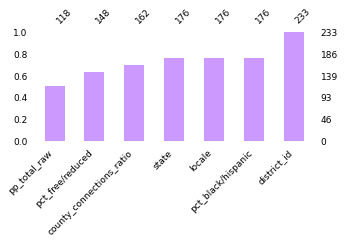

In [5]:
msno.bar(df_district,figsize=(5,2),sort="ascending",color="#cc99ff",fontsize=9)

<AxesSubplot:>

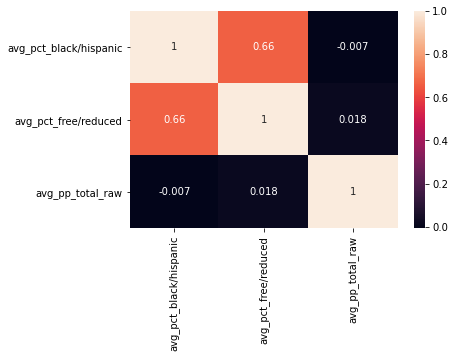

In [6]:
def avg_col(x):
    try:
        x_avg=sum(list(map(float,x.strip("[").split(", "))))/2
        return x_avg
    except:
        return x
df_district["avg_pct_black/hispanic"] = df_district["pct_black/hispanic"].apply(avg_col) 
df_district["avg_pct_free/reduced"] = df_district["pct_free/reduced"].apply(avg_col)
df_district["avg_pp_total_raw"] = df_district["pp_total_raw"].apply(avg_col)
sns.heatmap(data=df_district[["avg_pct_black/hispanic","avg_pct_free/reduced","avg_pp_total_raw"]].corr(),annot=True)

#### It seems so pct_black/hispanic and pct_free/reduced are correlated.Let's find how are districts distributed according to pct_black/hisponic,pct_free/reduced,county_connections_ratio.

Percentage of total number of districts having different pct_black/hisponic,pct_free/reduced,county_connections_ratio


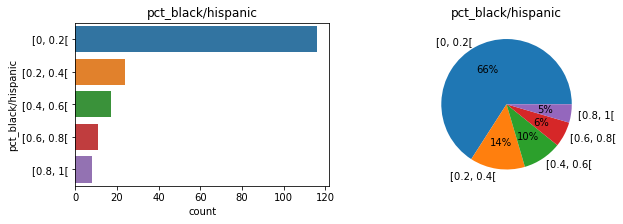

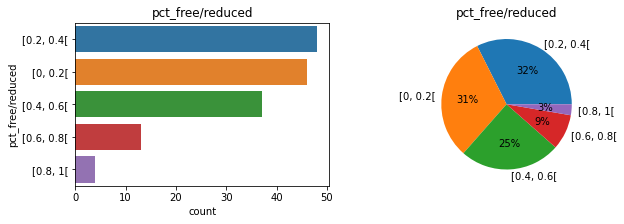

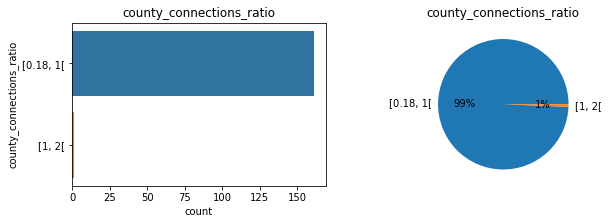

In [7]:
def func_plot(df,col1):
    fig,ax = plt.subplots(1,2,figsize=(10,3))
    sns.countplot(data=df,y=col1,ax=ax[0],order=df[col1].value_counts().index,orient="v")
    ax[0].set_title(col1)
    ax[1].pie(x=df[col1].value_counts(),labels=df[col1].value_counts().index,autopct='%1.0f%%')
    ax[1].set_title(col1)
print("Percentage of total number of districts having different pct_black/hisponic,pct_free/reduced,county_connections_ratio")
func_plot(df_district,"pct_black/hispanic")
func_plot(df_district,"pct_free/reduced")
func_plot(df_district,"county_connections_ratio")    

Percentage of total number of districts having different pp_total_raw


,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw,avg_pct_black/hispanic,avg_pct_free/reduced,avg_pp_total_raw
128,1470,New York,Rural,"[0, 0.2[","[0.4, 0.6[","[0.18, 1[","[32000, 34000[",0.100000,0.500000,33000.000000


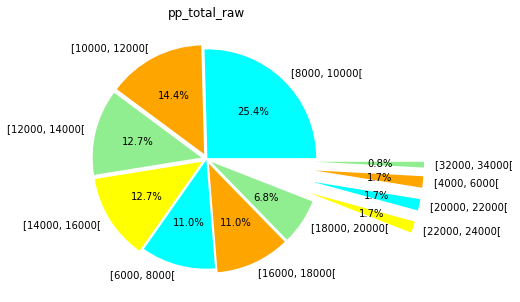

In [8]:
print("Percentage of total number of districts having different pp_total_raw")
fig,ax = plt.subplots(1,1,figsize=(5,5))
explode = (0.01, 0.05, 0.05, 0.05,0.01,0.05,0.05,1,1,1,1)
colors= ("cyan","orange","lightgreen","yellow")
ax.pie(x=df_district["pp_total_raw"].value_counts(),labels=df_district["pp_total_raw"].value_counts().index,autopct='%1.1f%%',explode=explode,colors=colors)
ax.set_title("pp_total_raw")
# 25.4% districts have per pupil total expenditure in the range of [8000,10000) . There is only one district in state whose per pupil expenditure is in the range of [32000, 34000).
df_district[df_district["pp_total_raw"]=="[32000, 34000["].style.applymap(lambda x: 'color:red;')

Text(0.5, 1.0, 'dis_locale')

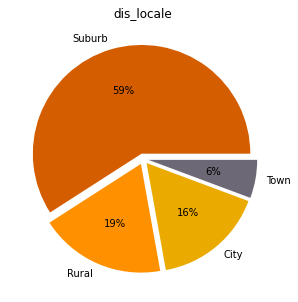

In [9]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
explode = (0.05, 0.05, 0.05, 0.05)
colors=(["#d45d00","#ff9100","#eaaa00","#6d6875"])
ax.pie(x=df_district.locale.value_counts().values,explode=explode,labels=df_district.locale.value_counts().index,autopct='%1.0f%%',colors=colors)
ax.set_title("dis_locale")

pct_black/hispanic in every locale area


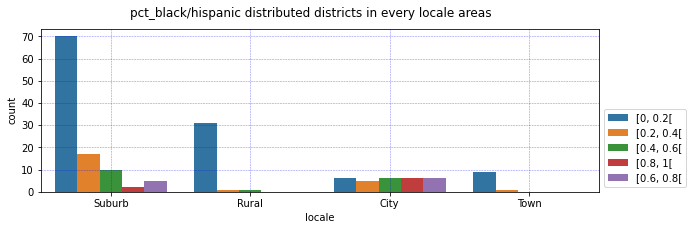

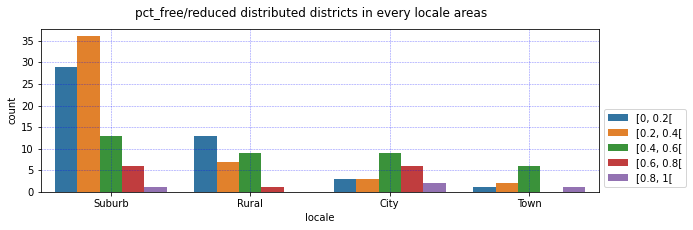

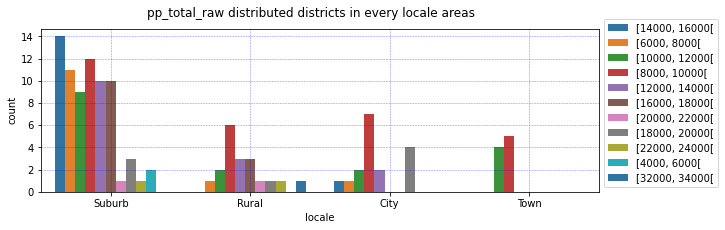

In [10]:
def local_count(df,col1,col2):
    fig,ax=plt.subplots(figsize=(10,3))
    plt.suptitle(f"{col2} distributed districts in every locale areas")
    sns.countplot(data=df,x=col1,hue=col2,order=df[col1].value_counts().index,palette="tab10",orient="v")
    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1,0), loc="lower left")
local_count(df_district,"locale","pct_black/hispanic")
local_count(df_district,"locale","pct_free/reduced")
local_count(df_district,"locale","pp_total_raw")
print("pct_black/hispanic in every locale area")

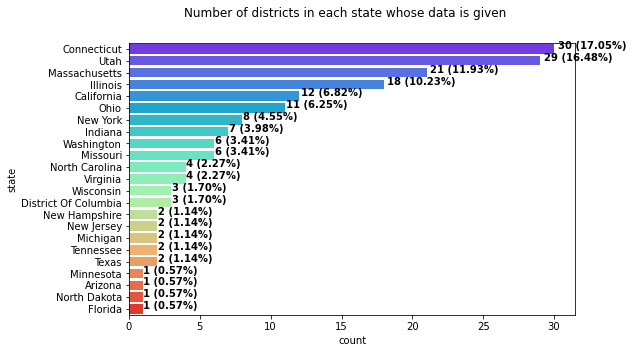

In [11]:
fig,ax=plt.subplots(figsize=(8,5))
sns.countplot(data=df_district,y="state",order=df_district.state.value_counts().index,palette="rainbow",orient="v")
fig.suptitle("Number of districts in each state whose data is given")
total=df_district["state"].value_counts().sum()
for i,v in enumerate(df_district["state"].value_counts().sort_values(ascending=False).values):
    frac1 = (v/total)*100
    frac = "{:.2f}".format(frac1)
    v1 = str(v)+' ('+str(frac)+'%)'
    ax.text(v*1.01, i, v1,fontsize=10,color='black',weight='bold')

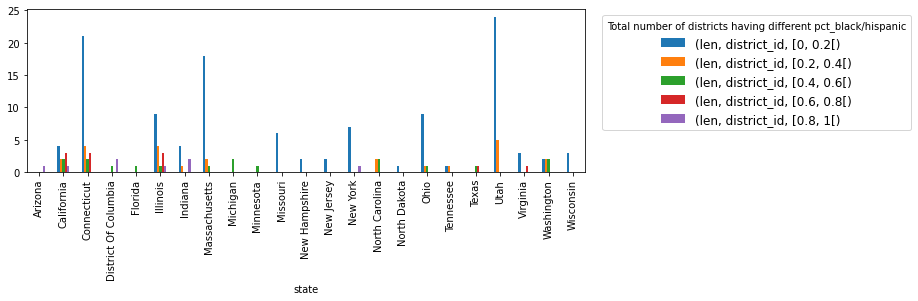

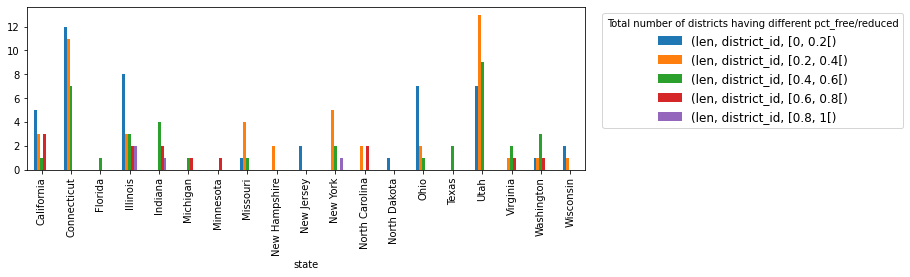

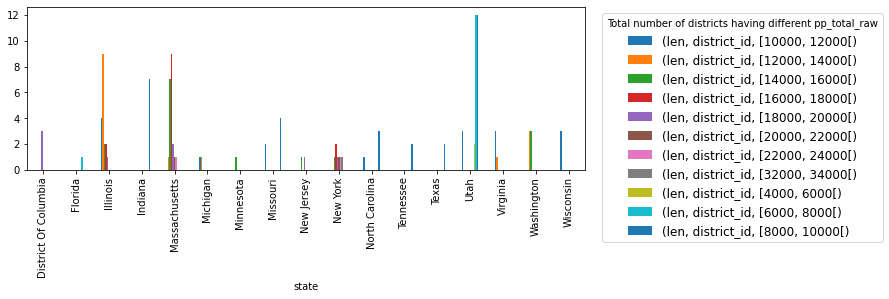

In [12]:
def state_pivot(df,col1,col2,col3):
    pv=pd.pivot_table(data=df,index=[col3],aggfunc=[len],values=[col2],columns=[col1],fill_value=0)
    pv.plot.bar(figsize=(10,3)).legend(bbox_to_anchor=(1.02, 1),title=f"Total number of districts having different {col1}",fontsize='large')
state_pivot(df_district,"pct_black/hispanic","district_id","state")
state_pivot(df_district,"pct_free/reduced","district_id","state")
state_pivot(df_district,"pp_total_raw","district_id","state")

In [13]:
df_district["state"].value_counts().index

Index(['Connecticut', 'Utah', 'Massachusetts', 'Illinois', 'California',
       'Ohio', 'New York', 'Indiana', 'Washington', 'Missouri',
       'North Carolina', 'Virginia', 'Wisconsin', 'District Of Columbia',
       'New Hampshire', 'New Jersey', 'Michigan', 'Tennessee', 'Texas',
       'Minnesota', 'Arizona', 'North Dakota', 'Florida'],
      dtype='object')

### Product information data
The product file `products_info.csv` includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy. Data were labeled by our team. Some products may not have labels due to being duplicate, lack of accurate url or other reasons.

| Name | Description |
| :--- | :----------- |
| LP ID| The unique identifier of the product |
| URL | Web Link to the specific product |
| Product Name | Name of the specific product |
| Provider/Company Name | Name of the product provider |
| Sector(s) | Sector of education where the product is used |
| Primary Essential Function | The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled |

In [14]:
df_product = pd.read_csv("products_info.csv")
df_product.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


<AxesSubplot:>

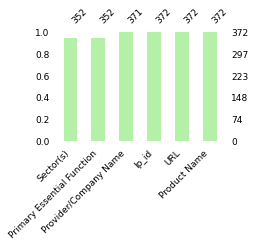

In [15]:
df_product=df_product.rename(columns={"LP ID":"lp_id"})
msno.bar(df_product,figsize=(3,2),sort="ascending",color="#b4f0a7",fontsize=9)

Name of Companies having maximum products


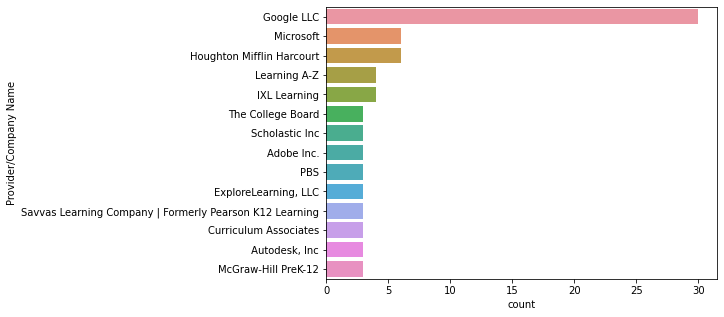

In [16]:
plt.figure(figsize=(7,5))
sns.countplot(data=df_product,y="Provider/Company Name",orient="v",order=df_product["Provider/Company Name"].value_counts().head(14).index)
print("Name of Companies having maximum products")

<AxesSubplot:xlabel='count', ylabel='Sector(s)'>

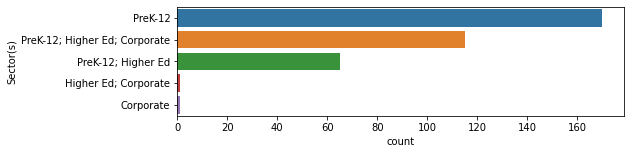

In [17]:
fig,ax=plt.subplots(figsize=(8,2))
sns.countplot(data=df_product,y="Sector(s)",order=df_product["Sector(s)"].value_counts().index,orient="v")

#### From the above result we can conclude, The Prek-12 sector used maximum products at covid time.

### Evaluate the number of products used in LC,CM,SDO Functinality.

<AxesSubplot:xlabel='Primary_essential_func', ylabel='count'>

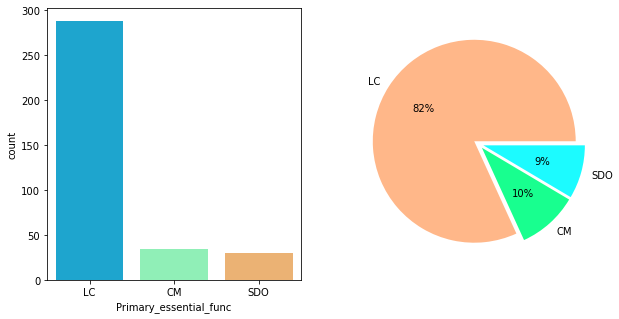

In [18]:
def func(x):
    try:
        if x[:2]=="LC":
            return "LC"
        elif x[:2]=="CM":
            return "CM"
        elif x[:3]=="SDO":
            return "SDO"
    except:
        return x
df_product["Primary_essential_func"]=df_product["Primary Essential Function"].apply(func)
fig,ax=plt.subplots(1,2,figsize=(10,5))
explode=(0.05,0.05,0.05)
ax[1].pie(x=df_product["Primary_essential_func"].value_counts(),colors=["#ffb789","#18ff8f","#1cfbff"],labels=df_product["Primary_essential_func"].value_counts().index,explode=explode,autopct="%1.0f%%")
sns.countplot(data=df_product,x="Primary_essential_func",orient="v",ax=ax[0],palette="rainbow")

### It means 82% of the products are used for "LC" functionality.

Text(0.5, 0.98, 'Primary_essential_subfunction')

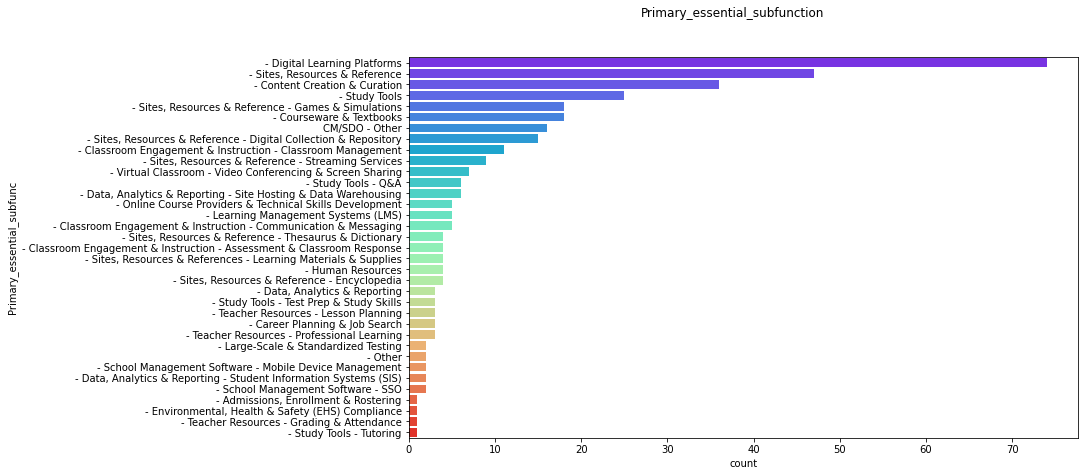

In [19]:
def sub_func(x):
    try:
        if x[:2]=="LC":
            return x[3:]
        elif x[:2]=="CM":
            return x[3:]
        elif x[:3]=="SDO":
            return x[4:]
    except:
        return x
df_product["Primary_essential_subfunc"]=df_product["Primary Essential Function"].apply(sub_func)   
plt.figure(figsize=(12,7))
sns.countplot(data=df_product,y="Primary_essential_subfunc",orient="v",palette="rainbow",order=df_product["Primary_essential_subfunc"].value_counts().index)
plt.suptitle("Primary_essential_subfunction")

### Most of the products are used for digital learning Platform

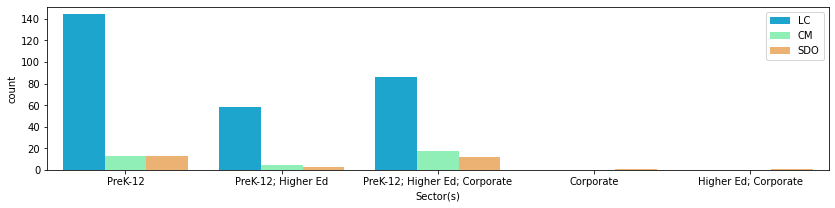

In [20]:
plt.figure(figsize=(14,3))
sns.countplot(data=df_product,x="Sector(s)",hue="Primary_essential_func",palette="rainbow")
plt.legend(loc=1)

### Engagement data
The engagement data are aggregated at school district level, and each file in the folder `engagement_data` represents data from one school district. The 4-digit file name represents `district_id` which can be used to link to district information in `district_info.csv`. The `lp_id` can be used to link to product information in `product_info.csv`.

| Name | Description |
| :--- | :----------- |
| time | date in "YYYY-MM-DD" |
| lp_id | The unique identifier of the product |
| pct_access | Percentage of students in the district have at least one page-load event of a given product and on a given day |
| engagement_index | Total page-load events per one thousand students of a given product and on a given day |

In [68]:
df_engagement=pd.read_csv("engagement_data.csv",index_col="Unnamed: 0")
df_engagement.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,93690.0,0.00,NaN,1000
1,2020-01-01,17941.0,0.03,0.90,1000
2,2020-01-01,65358.0,0.03,1.20,1000
3,2020-01-01,98265.0,0.57,37.79,1000
4,2020-01-01,59257.0,0.00,NaN,1000


<AxesSubplot:xlabel='pct_access', ylabel='engagement_index'>

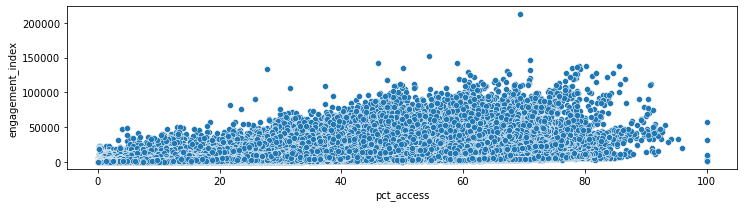

In [75]:
df_engagement["time"]=pd.to_datetime(df_engagement["time"])
df_engagement['month_name'] = df_engagement['time'].dt.month_name()
plt.figure(figsize=(12,3))
sns.scatterplot(x="pct_access",y="engagement_index",data=df_engagement)

In [78]:
df_engagement['month_name'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

### It seems so "pct_access" and "engagement_index" are highly correlated.

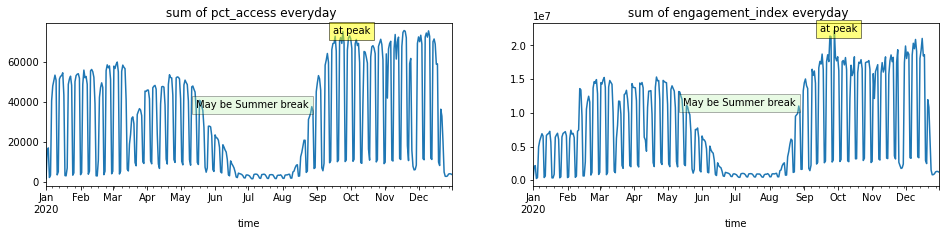

In [24]:
fig,ax=plt.subplots(1,2,figsize=(16,3))
def group_func(dataframe,col1,col2,y,i):
    dfr = dataframe.groupby(col1)[[col2]].sum()
    dfr[col2].plot(ax=ax[i])
    ax[i].set_title(f" sum of {col2} everyday")
    ax[i].text("2020-05-15",y,"May be Summer break", bbox=dict(facecolor='#b4f0a7', alpha=0.3),)
    ax[i].text("2020-09-15",y*2,"at peak", bbox=dict(facecolor='YELLOW', alpha=0.5))
group_func(df_engagement,"time","pct_access",37000,0)
group_func(df_engagement,"time","engagement_index",11000000,1)

<AxesSubplot:title={'center':'mean_engagement_index of each month'}, xlabel='month_name'>

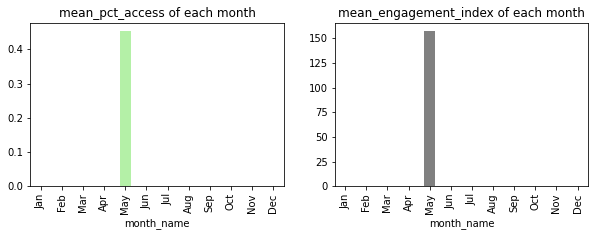

In [76]:
new_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df1=df_engagement.groupby("month_name").mean()[["pct_access","engagement_index"]]
df1=df1.reindex(new_order)
fig,ax=plt.subplots(1,2,figsize=(10,3))
df1["pct_access"].plot.bar(ax=ax[0],title="mean_pct_access of each month",color="#b4f0a7")
df1["engagement_index"].plot.bar(ax=ax[1],color="gray",title="mean_engagement_index of each month")

### From above graph we found that people in every state are more engaged after July in digital learning.

### In the month of June and July ,less percentage of students loaded the page and total page-load events are also minimum at this time. But after August, the graph is again increasing and digital connectivity is more after August and students are more engaged in e-learning platform.

Merge the dataframe df_engagement and df_district

In [79]:
df_engagement_district= pd.merge(df_engagement,df_district,on="district_id",how='inner',)
df_engagement_district.head()

,time,lp_id,pct_access,engagement_index,district_id,month,month_name,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,2020-01-01,93690.0,0.00,NaN,1000,1,January,Connecticut,Suburb,"[0.6, 0.8[","[0.2, 0.4[","[0.18, 1[",NaN
1,2020-01-01,17941.0,0.03,0.90,1000,1,January,Connecticut,Suburb,"[0.6, 0.8[","[0.2, 0.4[","[0.18, 1[",NaN
2,2020-01-01,65358.0,0.03,1.20,1000,1,January,Connecticut,Suburb,"[0.6, 0.8[","[0.2, 0.4[","[0.18, 1[",NaN
3,2020-01-01,98265.0,0.57,37.79,1000,1,January,Connecticut,Suburb,"[0.6, 0.8[","[0.2, 0.4[","[0.18, 1[",NaN
4,2020-01-01,59257.0,0.00,NaN,1000,1,January,Connecticut,Suburb,"[0.6, 0.8[","[0.2, 0.4[","[0.18, 1[",NaN


### Let's see how each state engaged in e-learning platform during pandemic 

In [80]:
us_state_to_abbrev = {"Arizona": "AZ","California": "CA","Connecticut": "CT","Florida": "FL","Illinois": "IL",
                      "Indiana": "IN","Massachusetts": "MA","Michigan": "MI","Minnesota": "MN","Missouri": "MO",
                      "New Hampshire": "NH","New Jersey": "NJ","New York": "NY","North Carolina": "NC",
                      "North Dakota": "ND","Ohio": "OH","Tennessee": "TN","Texas": "TX","Utah": "UT",
                      "Virginia": "VA","Washington": "WA","Wisconsin": "WI","District Of Columbia": "DC"}
def state_desc(df,col1,col2,col3,col4,col5):
    state_desc = df.groupby([col1]).mean().sort_values(col2,ascending=False).drop([col3,col4,col5],axis=1)
    plt.figure(figsize=(10,3))
    plt.xticks(rotation=70)
    plt.ylabel("Mean engagement index of every state")
    sns.barplot(x=state_desc.index,y=col2,data=state_desc)
    state_desc["state_ab"]=state_desc.index.map(us_state_to_abbrev)
    data = dict(type = 'choropleth',
        locationmode = 'USA-states',
        locations = state_desc["state_ab"],
        z = state_desc[col2],
        text = state_desc.index,
        colorscale= 'Portland',
        colorbar = {'title' : col2})
    layout = dict(title = col2,
              geo = {'scope':'usa'})
    choromap = go.Figure(data = [data],layout = layout)
    iplot(choromap,validate=False)

###  States in descending order of  engagement index in year 2020  means The name of state in which students have loaded maximum page events, will come first.

In [ ]:
state_desc(df_engagement_district,"state","engagement_index","lp_id","pct_access","district_id")

### After comparing the graph of mean engagement_index of every states, we found that state "Arizona" has maximum page load_events.

In [ ]:
all_state_names=df_engagement_district[df_engagement_district["state"].notnull()]["state"].unique()
pv=pd.pivot_table(data=df_engagement_district,index="time",aggfunc="mean",values="engagement_index",columns="state",fill_value=0)
pv.plot(figsize=(19,6)).legend(bbox_to_anchor=(1.02, 1))

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(15,7))
def district_engagement(df,col1,col2,color,i,j):
    
    df.groupby(col1).mean()[[col2]].sort_values(col2,ascending=False).plot.bar(color=color,ax=ax[i,j])
    ax[i,j].set_title(f"mean of engagement_index of districts having different {col1}")
    ax[i,j].set_ylabel("mean of engagement_index")
    ax[i,j].tick_params(axis='x', rotation=45)
    fig.tight_layout(pad=3.0)
district_engagement(df_engagement_district,"pct_free/reduced","engagement_index","lightyellow",0,0)
district_engagement(df_engagement_district,"pct_black/hispanic","engagement_index","lightblue",0,1)
district_engagement(df_engagement_district,"pp_total_raw","engagement_index","gray",1,0)
district_engagement(df_engagement_district,"locale","engagement_index","orange",1,1)

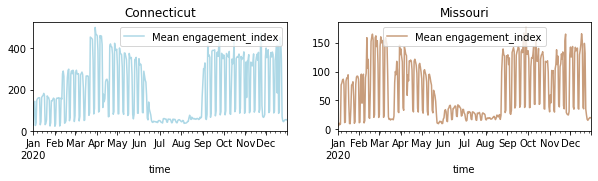

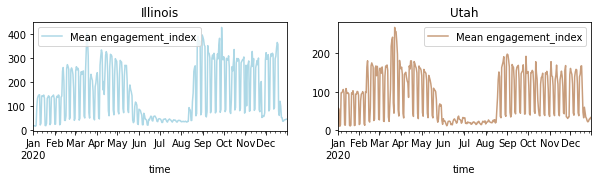

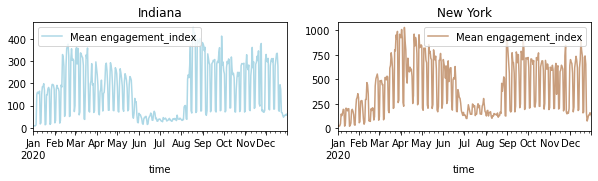

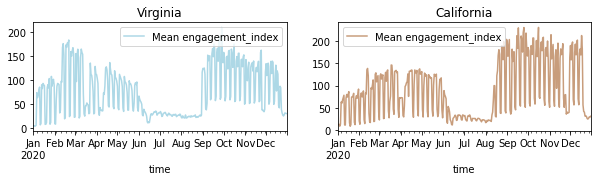

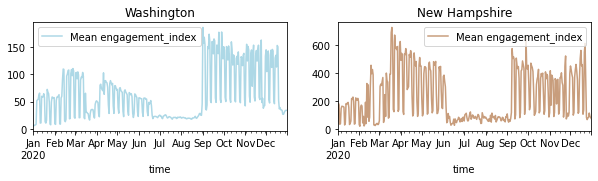

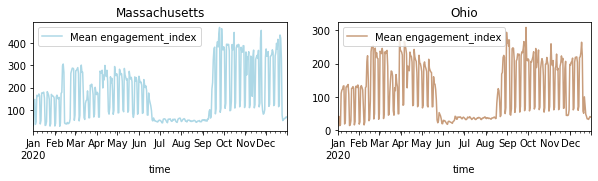

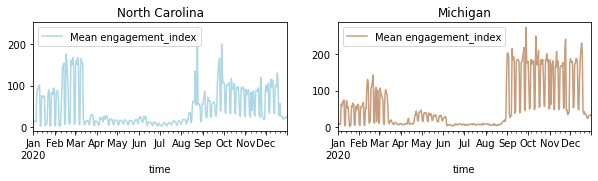

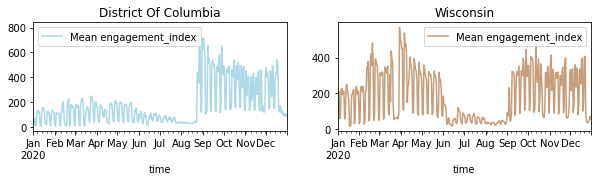

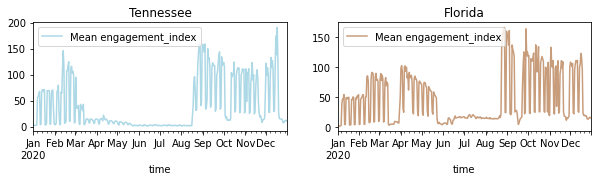

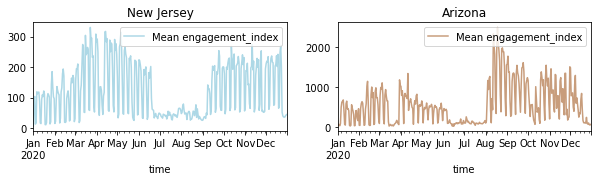

In [28]:
def state_eng(dataframe1,dataframe2,col1,col2):
    dfr1 = dataframe1.groupby(col1)[[col2]].mean()
    dfr2 = dataframe2.groupby(col1)[[col2]].mean()
    fig,ax=plt.subplots(1,2,figsize=(10,2))
    dfr1[col2].plot(ax=ax[0],color="lightblue")
    dfr2[col2].plot(ax=ax[1],color="#C89D7C")
    ax[0].set_title(state_names[i])
    ax[1].set_title(state_names[i+1])
    ax[0].legend(["Mean engagement_index"])
    ax[1].legend(["Mean engagement_index"])
    
    
state_names = ['Connecticut', 'Missouri', 'Illinois', 'Utah', 'Indiana','New York', 'Virginia', 'California', 
               'Washington','New Hampshire', 'Massachusetts', 'Ohio', 'North Carolina', 'Michigan',
               'District Of Columbia', 'Wisconsin','Tennessee','Florida','New Jersey', 'Arizona']
for i in range(0,len(state_names),2):
    df1=df_engagement_district[df_engagement_district["state"]==state_names[i]]
    df2=df_engagement_district[df_engagement_district["state"]==state_names[i+1]]
    state_eng(df1,df2,"time","engagement_index")
    

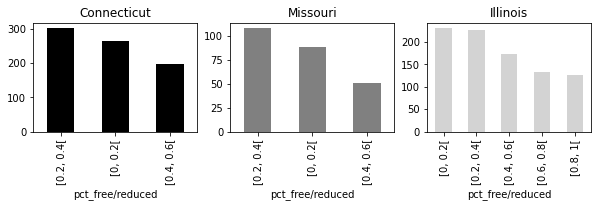

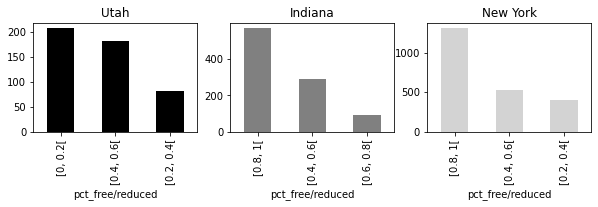

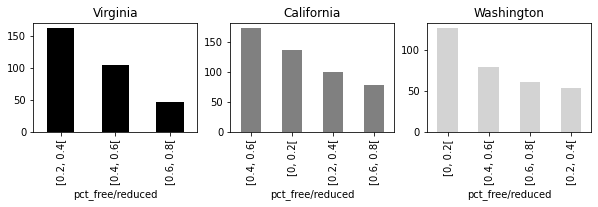

In [29]:
def state_eng_mean(dataframe1,dataframe2,dataframe3,col1,col2):
    dfr1 = dataframe1.groupby(col1)[[col2]].mean().sort_values(by=col2,ascending=False)
    dfr2 = dataframe2.groupby(col1)[[col2]].mean().sort_values(by=col2,ascending=False)
    dfr3 = dataframe3.groupby(col1)[[col2]].mean().sort_values(by=col2,ascending=False)
    fig,ax=plt.subplots(1,3,figsize=(10,2))
    dfr1[col2].plot.bar(ax=ax[0],color="black")
    dfr2[col2].plot.bar(ax=ax[1],color="gray")
    dfr3[col2].plot.bar(ax=ax[2],color="lightgray")
    ax[0].set_title(state_names[i])
    ax[1].set_title(state_names[i+1])
    ax[2].set_title(state_names[i+2])
    
    
state_names = ['Connecticut', 'Missouri', 'Illinois', 'Utah', 'Indiana','New York', 'Virginia', 'California', 'Washington']
for i in range(0,len(state_names),3):
    df1=df_engagement_district[df_engagement_district["state"]==state_names[i]]
    df2=df_engagement_district[df_engagement_district["state"]==state_names[i+1]]
    df3=df_engagement_district[df_engagement_district["state"]==state_names[i+2]]
    state_eng_mean(df1,df2,df3,"pct_free/reduced","engagement_index")

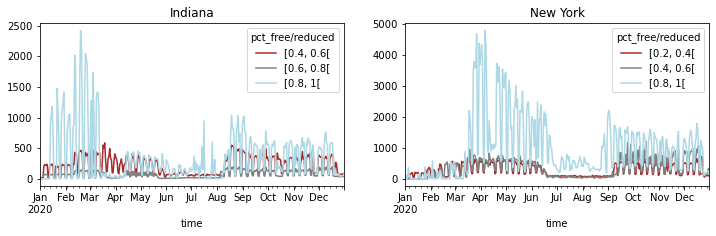

In [30]:
def mean_engagement_func_group(df,col1,color):
    df.pivot_table(index="time",aggfunc="mean",values="engagement_index",columns=col1,fill_value=0).plot(title=state_names[i],color=color,ax=ax[i])

fig,ax=plt.subplots(1,2,figsize=(12,3))
state_names = ["Indiana",'New York']

for i in range(len(state_names)):
    df=df_engagement_district[df_engagement_district["state"]==state_names[i]]
    mean_engagement_func_group(df,"pct_free/reduced",["brown","gray","lightblue"])


It means districts having pct_black/hispanic=(0.8,1)(5% districts), pct_free/reduced =(0.8,1)(3% districts) has highest 
mean engagement index. It seems so the goverment and people are helping high poverty categories (pct_free/reduced =(0.8,1)) of people in e-learning and digital platform.
<br>
<br>
On the other side districts having pct_black/hispanic=(0,0.2), pct_free/reduced =(0,0.2) have also good mean enagegement index that means less students are eligible for free lunch and these district's people are more financial established so they can spend money for digital and e-learning platform or may be the other reason.
<br>
<br>
"Rural" locales has more mean page load events than City,suburb,Town and students in Rural areas are more dependent on digital learning
<br>
<br>
Mean engagement index of every state after August is more than or equal to before June in every state. Arizona is the state  whose mean_engagement_index has increased more than double from earlier between August and September.
<br>
<br>
There is only one district whose per pupil expenditure(pp_total_raw) is [32000,34000) and this district has maximum mean page load events.
<br>
<br>
Mean engagement index of 80/100% high poverty group (pct_free/reduced) in states New york and Indiana have unusual trends and their mean page load events are  less than before June.District of columbia has sudden increment in August.
<br>
<br>
**Note: I am taking mean engagement index not sum of engagement index**

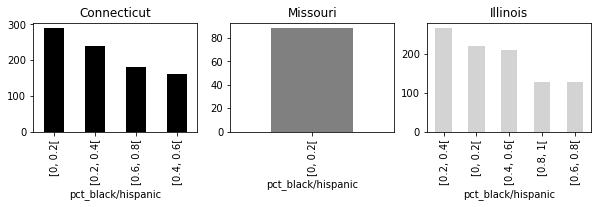

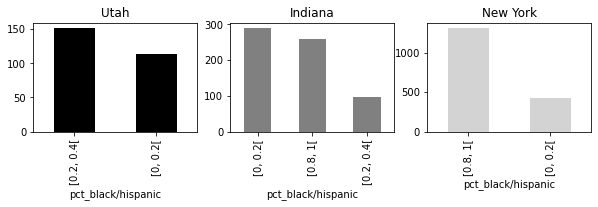

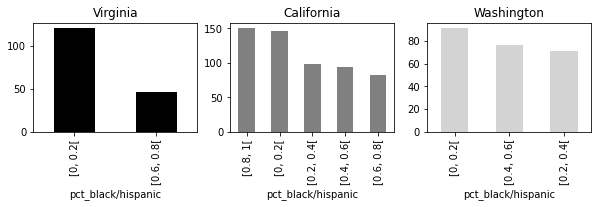

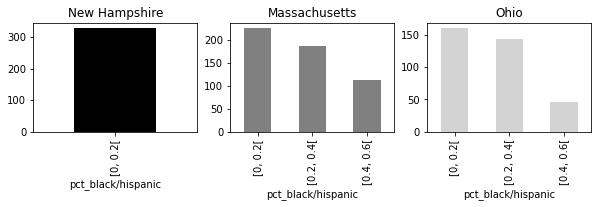

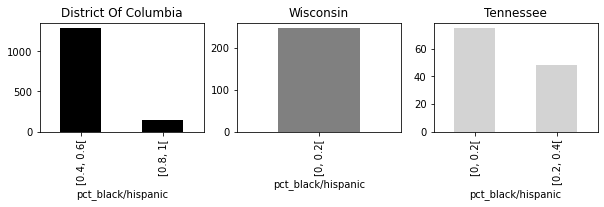

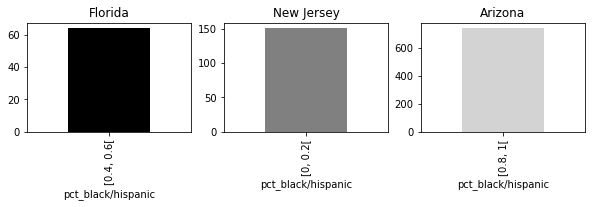

In [45]:
state_names = ['Connecticut', 'Missouri', 'Illinois', 'Utah', 'Indiana','New York', 'Virginia', 'California', 
               'Washington','New Hampshire', 'Massachusetts', 'Ohio', 'District Of Columbia', 'Wisconsin','Tennessee','Florida','New Jersey', 'Arizona']
for i in range(0,len(state_names),3):
    df1=df_engagement_district[df_engagement_district["state"]==state_names[i]]
    df2=df_engagement_district[df_engagement_district["state"]==state_names[i+1]]
    df3=df_engagement_district[df_engagement_district["state"]==state_names[i+2]]
    state_eng_mean(df1,df2,df3,"pct_black/hispanic","engagement_index")

**pct_black/hispanic(0.8,1) group of state "New York" has highest mean engagement index more than 1000 in comaprison of other state.**

##  If we take sum of engagement index in different situation

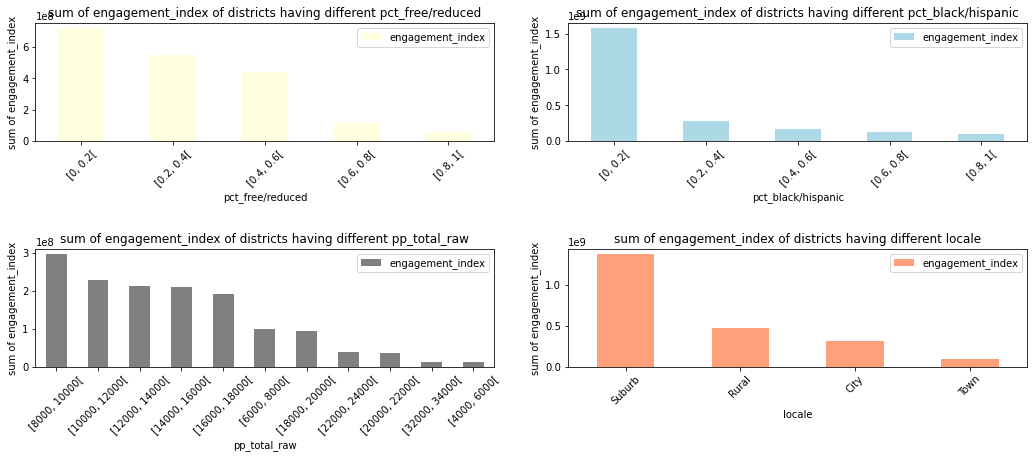

In [52]:
fig,ax=plt.subplots(2,2,figsize=(15,7))
def district_engagement_sum(df,col1,col2,color,i,j):
    
    df.groupby(col1).sum()[[col2]].sort_values(col2,ascending=False).plot.bar(color=color,ax=ax[i,j])
    ax[i,j].set_title(f"sum of engagement_index of districts having different {col1}")
    ax[i,j].set_ylabel("sum of engagement_index")
    ax[i,j].tick_params(axis='x', rotation=45)
    fig.tight_layout(pad=3.0)
district_engagement_sum(df_engagement_district,"pct_free/reduced","engagement_index","lightyellow",0,0)
district_engagement_sum(df_engagement_district,"pct_black/hispanic","engagement_index","lightblue",0,1)
district_engagement_sum(df_engagement_district,"pp_total_raw","engagement_index","gray",1,0)
district_engagement_sum(df_engagement_district,"locale","engagement_index","#FFA07A",1,1)

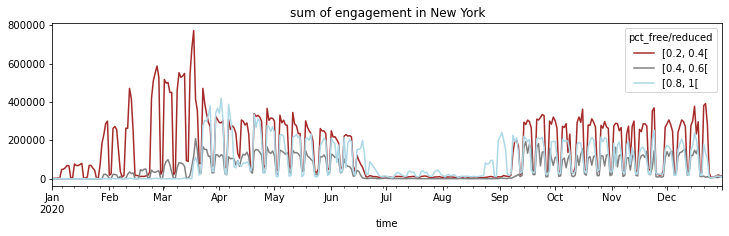

In [50]:
def sum_engagement_func_group(df,col1,color):
    df.pivot_table(index="time",aggfunc="sum",values="engagement_index",columns=col1,fill_value=0).plot(title=f"sum of engagement in {state_names[i]}",color=color,ax=ax)

fig,ax=plt.subplots(1,1,figsize=(12,3))
state_names = ['New York']

for i in range(len(state_names)):
    df=df_engagement_district[df_engagement_district["state"]==state_names[i]]
    sum_engagement_func_group(df,"pct_free/reduced",["brown","gray","lightblue"])


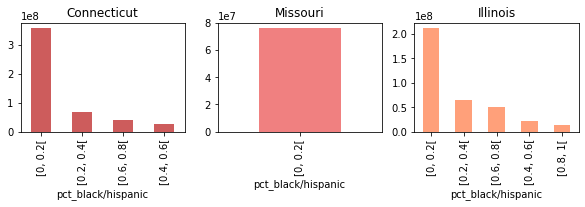

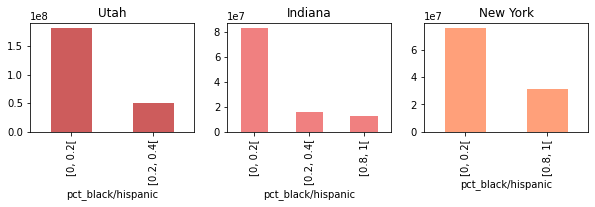

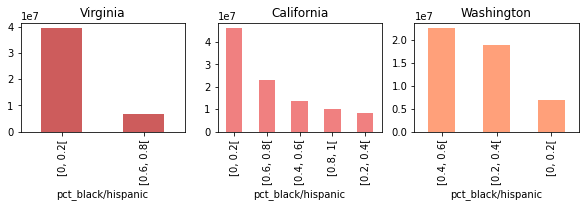

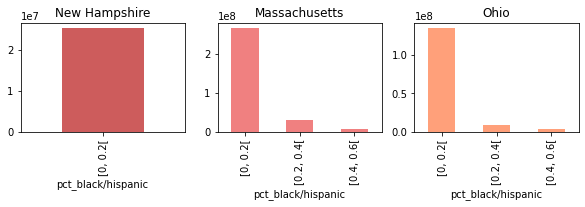

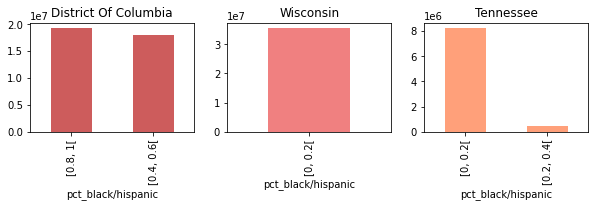

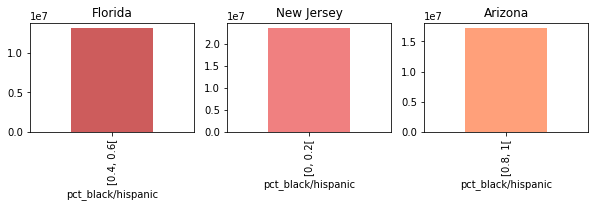

In [51]:
def state_eng_sum(dataframe1,dataframe2,dataframe3,col1,col2):
    dfr1 = dataframe1.groupby(col1)[[col2]].sum().sort_values(by=col2,ascending=False)
    dfr2 = dataframe2.groupby(col1)[[col2]].sum().sort_values(by=col2,ascending=False)
    dfr3 = dataframe3.groupby(col1)[[col2]].sum().sort_values(by=col2,ascending=False)
    fig,ax=plt.subplots(1,3,figsize=(10,2))
    dfr1[col2].plot.bar(ax=ax[0],color="#CD5C5C")
    dfr2[col2].plot.bar(ax=ax[1],color="#F08080")
    dfr3[col2].plot.bar(ax=ax[2],color="#FFA07A")
    ax[0].set_title(state_names[i])
    ax[1].set_title(state_names[i+1])
    ax[2].set_title(state_names[i+2])
    
    
state_names = ['Connecticut', 'Missouri', 'Illinois', 'Utah', 'Indiana','New York', 'Virginia', 'California', 
               'Washington','New Hampshire', 'Massachusetts', 'Ohio', 'District Of Columbia', 'Wisconsin','Tennessee','Florida','New Jersey', 'Arizona']
for i in range(0,len(state_names),3):
    df1=df_engagement_district[df_engagement_district["state"]==state_names[i]]
    df2=df_engagement_district[df_engagement_district["state"]==state_names[i+1]]
    df3=df_engagement_district[df_engagement_district["state"]==state_names[i+2]]
    state_eng_sum(df1,df2,df3,"pct_black/hispanic","engagement_index")

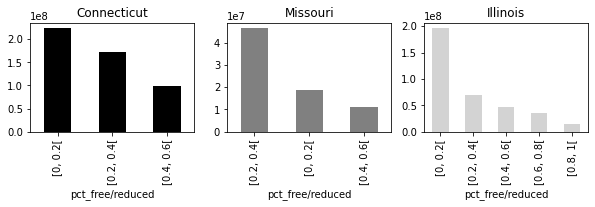

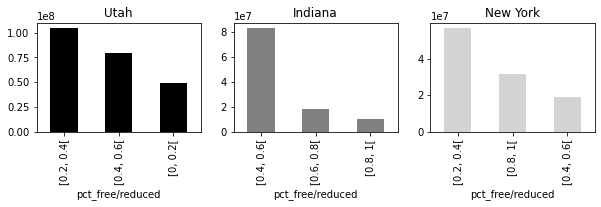

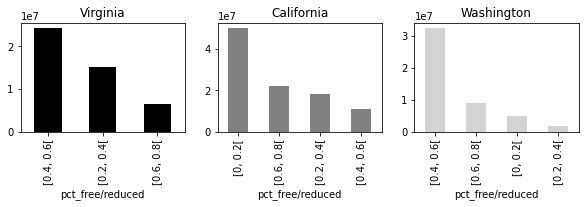

In [35]:
state_names = ['Connecticut', 'Missouri', 'Illinois', 'Utah', 'Indiana','New York', 'Virginia', 'California', 'Washington']
for i in range(0,len(state_names),3):
    df1=df_engagement_district[df_engagement_district["state"]==state_names[i]]
    df2=df_engagement_district[df_engagement_district["state"]==state_names[i+1]]
    df3=df_engagement_district[df_engagement_district["state"]==state_names[i+2]]
    state_eng_sum(df1,df2,df3,"pct_free/reduced","engagement_index")

It means districts having pct_black/hispanic=(0,0.2)(66% districts), pct_free/reduced =(0, 0.2)(31% districts) has highest 
sum of engagement index. These district's people are more financial established as well as highest in numbers. 
<br>
<br>
"Suburb" locales (59% districts) has more sum of page load events than City,Rural,Town and students in suburb areas are more dependent on digital learning as these districts are highest in numbers.

In [36]:
df_engagement_district_product= pd.merge(df_engagement_district,df_product,on="lp_id",how='inner')

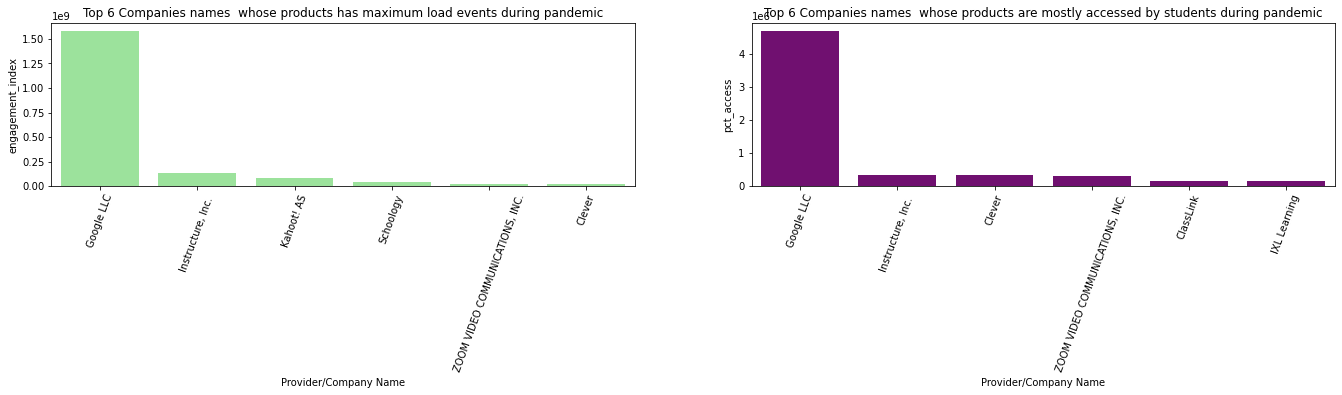

In [82]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

fig,ax=plt.subplots(1,2,figsize=(23,3))
def top_6_company_name(df,col1,col2,text,i,color):
    Top_6_company_name=df.groupby(col1).sum()[[col2]].sort_values(col2,ascending=False).head(6)
    ax[i].set_xticklabels(ax[i].get_xticks(),rotation=70)
    ax[i].set_title(text)
    sns.barplot(x=Top_6_company_name.index,y=col2,data=Top_6_company_name,color=color,ax=ax[i])
top_6_company_name(df_engagement_district_product,"Provider/Company Name","engagement_index","Top 6 Companies names  whose products has maximum load events during pandemic",0,"lightgreen")
top_6_company_name(df_engagement_district_product,"Provider/Company Name","pct_access","Top 6 Companies names  whose products are mostly accessed by students during pandemic",1,"purple")

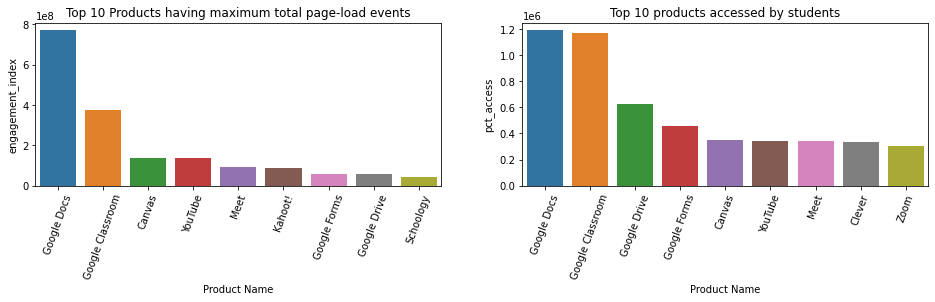

In [83]:
fig,ax=plt.subplots(1,2,figsize=(16,3))
def Top10_Products(df1,df2,col1,col2,col3,i,text):
    Top10_product = df1.groupby([col1]).sum().sort_values(col2,ascending=False).head(10)
    top_10_product = pd.merge(Top10_product,df2,how="left", left_on=Top10_product.index,right_on=col1)[[col1,col3,col2]]
    ax[i].set_xticklabels(ax[i].get_xticks(),rotation=70)
    ax[i].set_title(text)
    sns.barplot(x=col3,y=col2,data=top_10_product,ax=ax[i])
Top10_Products(df_engagement,df_product,"lp_id","engagement_index","Product Name",0,"Top 10 Products having maximum total page-load events")
Top10_Products(df_engagement,df_product,"lp_id","pct_access","Product Name",1,"Top 10 products accessed by students")

Text(0, 0.5, 'sum of engagement_index')

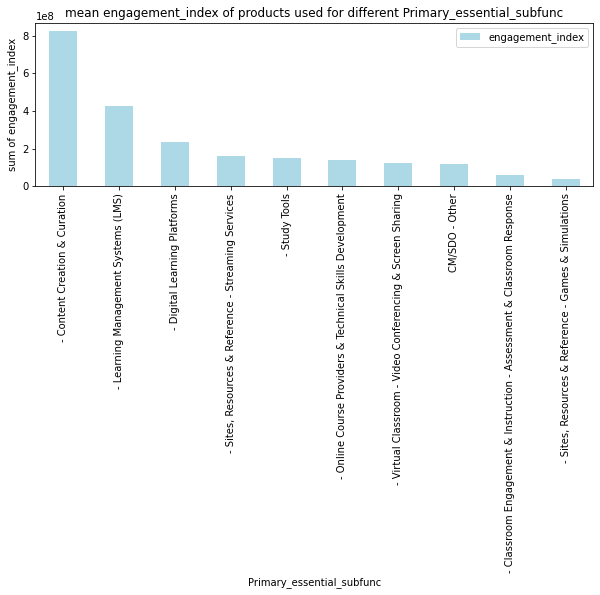

In [39]:
fig,ax=plt.subplots(1,1,figsize=(10,3))
df_engagement_district_product.groupby("Primary_essential_subfunc").sum()[["engagement_index"]].sort_values("engagement_index",ascending=False).head(10).plot.bar(color="lightblue",ax=ax)
ax.set_title(f"mean engagement_index of products used for different Primary_essential_subfunc")
ax.set_ylabel("sum of engagement_index")

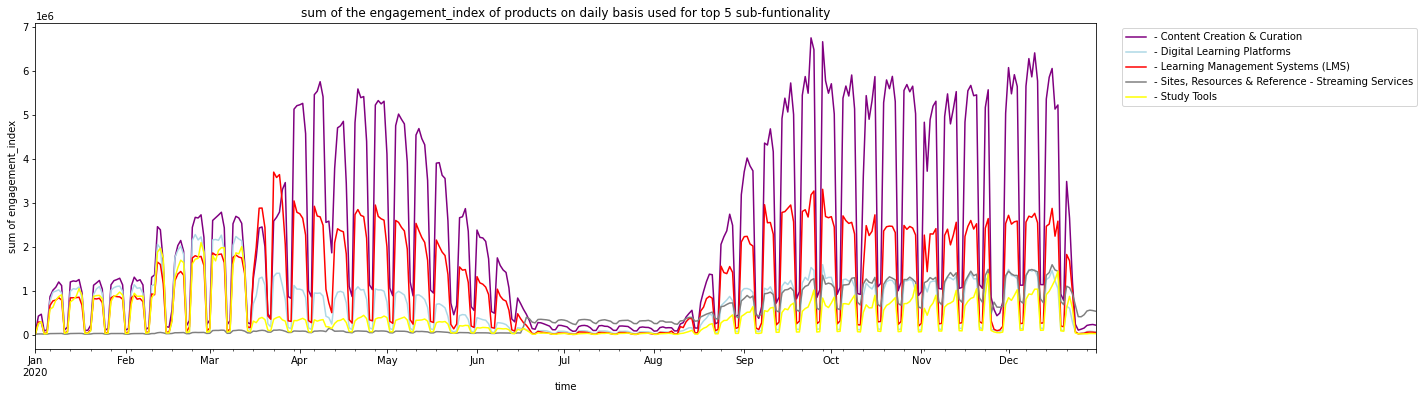

In [40]:
# I want the dataframe where primary essential subfunctions are Top 5 i.e.content creation,LMS, digital learning platform,site resource,study tools.
df_top_5_subfunction=df_engagement_district_product[df_engagement_district_product["Primary_essential_subfunc"].isin(df_engagement_district_product.groupby("Primary_essential_subfunc").sum()[["engagement_index"]].sort_values("engagement_index",ascending=False).head(5).index)]
top_5_subfunction_pivot=pd.pivot_table(data=df_top_5_subfunction,index="time",aggfunc="sum",values="engagement_index",columns="Primary_essential_subfunc",fill_value=0)
top_5_subfunction_pivot.plot(color=["purple","lightblue","red","gray","yellow"],figsize=(19,6),title="sum of the engagement_index of products on daily basis used for top 5 sub-funtionality",ylabel="sum of engagement_index").legend(bbox_to_anchor=(1.02, 1))

### According to the graph, Mostly products are used for Content creation, LMS and digital learning platform